In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

## Data cleaning

As the images I use do not have the consistent name convention, I will change it. 

In [42]:
paths = ['dataset/incorrect_mask', 'dataset/with_mask', 'dataset/without_mask']
for path in paths:
    i = 0
    for filename in os.listdir(path):
        os.rename(os.path.join(path,filename), os.path.join(path, str(i)+'.jpg'))
        i = i + 1

## Load the exemplary images

In [8]:
img_example = cv.imread('dataset/without_mask/0.jpg')
img_example1 = cv.imread('dataset/with_mask/0.jpg')

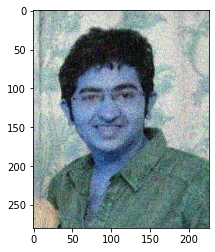

In [44]:
plt.imshow(img_example)

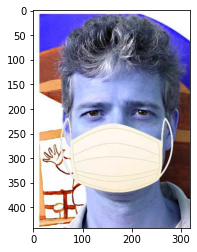

In [3]:
plt.imshow(img_example1)

As can be seen, the colors are probably swapped - matplotlib and openCV have different color channels order. Therefore, for the display purposes, I use a function that will correct the displayed image.

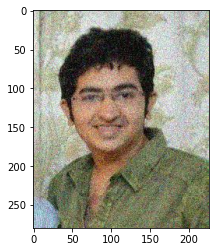

In [4]:
img_display = cv.cvtColor(img_example, cv.COLOR_BGR2RGB)
plt.imshow(img_display)

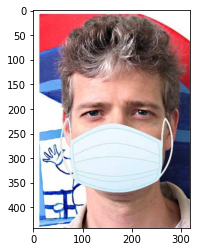

In [5]:
img_display1 = cv.cvtColor(img_example1, cv.COLOR_BGR2RGB)
plt.imshow(img_display1)

That is much better. Now I can go on and apply face detection - there is no need to look for a face mask beyond this region after all: this way, after the model detects the face, I can crop the image before giving in to the mask detection model, which will speed up its execution time.

## Face detection

For this task, I will use Cascade classifier provided by openCV, as well as their frontal face d. To actually use this, I have to convert my image to the greyscale.

In [9]:
img_gray1 = cv.cvtColor(img_example1, cv.COLOR_BGR2GRAY)
img_gray = cv.cvtColor(img_example, cv.COLOR_BGR2GRAY)

In [104]:
face_detector = cv.CascadeClassifier('models/haarcascade_frontalface_default.xml')

In [8]:
faces1 = face_detector.detectMultiScale(img_gray1, scaleFactor = 1.2, minNeighbors = 5)
faces = face_detector.detectMultiScale(img_gray, scaleFactor = 1.2, minNeighbors = 5)
faces

array([[ 38,  64, 118, 118]], dtype=int32)

The detector found a face and its coordinates on the image. Let's see where it lies:

In [9]:
for (a, b, c, d) in faces:
    crop_img = img_display[b:b+d, a:a+c]
    cv.rectangle(img_display, (a, b), (a+c, b+d), (0, 0, 255), 2)
for (a, b, c, d) in faces1:
    crop_img1 = img_display1[b:b+d, a:a+c]
    cv.rectangle(img_display1, (a, b), (a+c, b+d), (0, 0, 255), 2)

That should do it. Let's display the image:

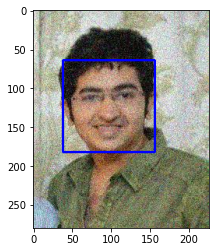

In [10]:
plt.imshow(img_display)

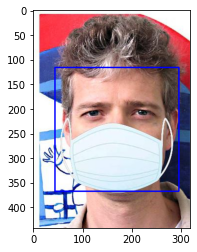

In [11]:
plt.imshow(img_display1)

I used the blue frame as it have not checked the appearance of the mask yet. Well, I can crop it already in fact. I did it for the display photos during the rectangle addition so that I wouldn't have to loop through the coordinates again.

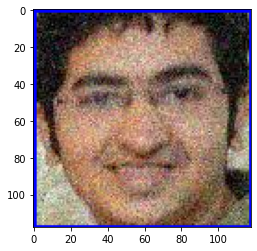

In [12]:
plt.imshow(crop_img)

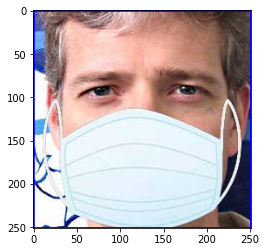

In [13]:
plt.imshow(crop_img1)

Wonderful! I now have smaller regions to take care of. However, I shall rescale them before forwarding them into the next model.

In [14]:
scale_size = (240, 240)

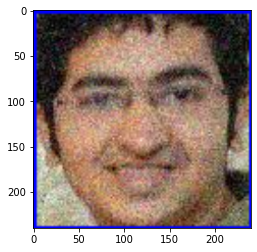

In [15]:
plt.imshow(cv.resize(crop_img, scale_size))

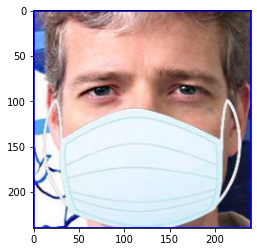

In [16]:
plt.imshow(cv.resize(crop_img1, scale_size))

To sum up this part, I can do the following before checking the mask correctness:
* load the image
* make it into the grayscale
* detect all the faces on it and save their coordinates - there will be needed for the annotations later on
* crop the image to face only - I will have to consider what to do in case of more than one on the image, but it will only be a case for user's input
* depending on the model I will use, I may have to flatten the image representation

## Prepare data

In [3]:
exts = ["jpg","png"]

In [4]:
masked = [glob.glob('dataset/with_mask/*.%s' % ext) for ext in exts]
img_m = [cv.imread(img) for i in masked for img in i if cv.imread(img) is not None]

In [5]:
unmasked = [glob.glob('dataset/without_mask/*.%s' % ext) for ext in exts]
img_u = [cv.imread(img) for i in unmasked for img in i if cv.imread(img) is not None]

In [6]:
incorrect = [glob.glob('dataset/incorrect_mask/*.%s' % ext) for ext in exts]
img_i = [cv.imread(img) for i in incorrect for img in i if cv.imread(img) is not None]

As I will create labels later on, I do not have to worry about number of cropped images.

In [102]:
def get_faces(img, model, scaleFactor, minNeighbors, dimensions=(240, 240), for_display=False):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = model.detectMultiScale(img_gray, scaleFactor = scaleFactor, minNeighbors = minNeighbors)
    extracted = []
    coords = []
    for (a, b, c, d) in faces:
        crop_img = img_gray[b:b+d, a:a+c]
        if crop_img.size != 0 and crop_img.size != 1:
            crop_img = cv.resize(crop_img, dimensions)
            extracted.append(crop_img)
    if len(extracted) == 0:
        return None
    if for_display:
        return extracted, faces
    return extracted

This returns list of faces found in the picture. In turn, it gives us another level of nesting for the whole dataset. This means I need to unlist the results for each image before making a list of faces.

## Test and train data

I will divide each photo set into train and test data. For the rest data, I need to preserve the display photos and the coordinates of faces in order to make annotations on it.

In [7]:
masked_train, masked_test = img_m[: int(len(img_m) * .8)], img_m[int(len(img_m) * .8):]
unmasked_train, unmasked_test = img_u[: int(len(img_u) * .8)], img_u[int(len(img_u) * .8):]
incorrect_train, incorrect_test = img_i[: int(len(img_i) * .8)], img_i[int(len(img_i) * .8):]

### Train dataset prepatations

In [105]:
mfaces = [get_faces(image, face_detector, 1.2, 5) for image in masked_train if get_faces(image, face_detector, 1.2, 5) is not None]
mfaces = [face for image in mfaces for face in image]

ufaces = [get_faces(image, face_detector, 1.2, 5) for image in unmasked_train if get_faces(image, face_detector, 1.2, 5) is not None]
ufaces = [face for image in ufaces for face in image]

ifaces = [get_faces(image, face_detector, 1.2, 5) for image in incorrect_train if get_faces(image, face_detector, 1.2, 5) is not None]
ifaces = [face for image in ifaces for face in image]

Great! Now I have three lists with face samples, that need to be labeled and fed to the model.

#### Get the labels

In [10]:
mfaces_lbl = [2]* len(mfaces)
ifaces_lbl = [1]* len(ifaces)
ufaces_lbl = [0]* len(ufaces)

#### Merge it for the model

In [11]:
x_train = mfaces + ufaces + ifaces
Y_train = mfaces_lbl + ufaces_lbl + ifaces_lbl

I flatten the training data because of the model needs.

In [12]:
X_train = (np.array(x_train)).reshape((len(Y_train), -1))

### Test data

This will be what I will be doing with the input from the user: turining photos into grayscale, finding faces on the given photos, saving the coordinates, checking for the mask on the faces and then annotating the face on the displayed photo.

In [13]:
mtest, mcoords = map(list,zip(*[get_faces(image, face_detector, 1.2, 5, for_display=True) for image in masked_test if get_faces(image, face_detector, 1.2, 5) is not None]))
mtest = [face for image in mtest for face in image]

itest, icoords = map(list,zip(*[get_faces(image, face_detector, 1.2, 5, for_display=True) for image in incorrect_test if get_faces(image, face_detector, 1.2, 5) is not None]))
itest = [face for image in itest for face in image]

utest, ucoords = map(list,zip(*[get_faces(image, face_detector, 1.2, 5, for_display=True) for image in unmasked_test if get_faces(image, face_detector, 1.2, 5) is not None]))
utest = [face for image in utest for face in image]


I found the necessary regions for exemplary presentation later on. Now I shall find the labels for the train data.

In [109]:
mtest_lbl = [2]* len(mtest)
itest_lbl = [1]* len(itest)
utest_lbl = [0]* len(utest)

In [112]:
test_coords = mcoords + ucoords + icoords

In [110]:
x_test = mtest + utest + itest
Y_test = mtest_lbl + utest_lbl + itest_lbl

In [111]:
X_test = (np.array(x_test)).reshape((len(Y_test), -1))

## Build model

I will use scikit learn Random Forest Classifier to detect the mask or its lack.

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
mask_detector = RandomForestClassifier().fit(X_train, Y_train)

In [125]:
mask_detector.score(X_test, Y_test)

0.9312977099236641

## The results

In [18]:
mask_result = ["No mask detected!", "Incorrect mask placement!", "Mask well worn"]

In [19]:
mask_coloring = [(255, 0, 0), (255, 0, 0), (0, 255, 0)]

I will take an image from another dataset and try my model on it.

In [55]:
img = cv.imread('dataset/other.png')

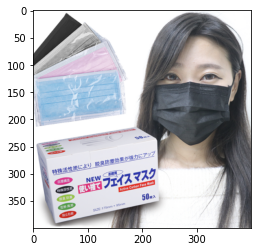

In [56]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [37]:
if get_faces(img, face_detector, 1.2, 5) is not None:
    faces, coords = get_faces(img, face_detector, 1.2, 5, for_display=True)
else:
    print("No face detected")

No face detected


This shows the limitations of the pretrained classifier I use in this project. It may sometimes fall to detect the face, therefore failing to detect the mask as well.

In [57]:
img = cv.imread('dataset/other_example.png')

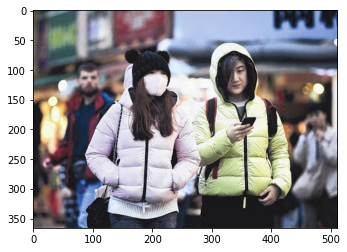

In [60]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [45]:
if get_faces(img, face_detector, 1.2, 5) is not None:
    faces, coords = get_faces(img, face_detector, 1.2, 5, for_display=True)
    print(len(faces))
else:
    print("No face detected")

1


Well, this time the classifier probably failed to detect the people on the left - almost all their features are obscured or blurred. I feed obtained face to the mask detector model.

In [52]:
faces = [face for image in faces for face in image]
faces_flattened = (np.array(faces)).reshape((len(coords), -1))

In [61]:
res = mask_detector.predict(faces_flattened)

In [99]:
font = cv.FONT_HERSHEY_SIMPLEX

In [102]:
img_display = cv.cvtColor(img, cv.COLOR_BGR2RGB)
i = 0
for coord in coords:
    cv.rectangle(img_display, (coord[0], coord[1]), (coord[0]+coord[2], coord[1]+coord[3]), mask_coloring[res[i]], 2)
    cv.putText(img_display,mask_result[res[i]],(coord[0], coord[1]-10), fontFace = font, fontScale=0.5, color=mask_coloring[res[i]],thickness=1, lineType=cv.LINE_AA)
    i += 1

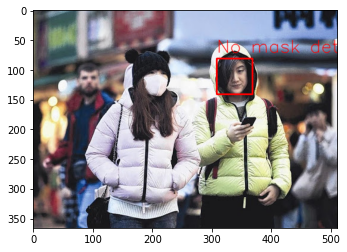

In [101]:
plt.imshow(img_display)

## Face detector change

As I was trying to implement the model for detection on videos, the current classifier proved to fail mostly for detecting the face. Then, my model had some trouble classifying. Therefore, I will try to check the results for DNN detector.

In [8]:
face_detector = cv.dnn.readNetFromCaffe("dataset/deploy.prototxt.txt", "dataset/res10_300x300_ssd_iter_140000.caffemodel")

In [152]:
img = cv.imread('dataset/other.png')
h, w = img.shape[:2]
blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)), 1.0,
(300, 300), (104.0, 117.0, 123.0))
face_detector.setInput(blob)
faces = face_detector.forward()
for i in range(faces.shape[2]):
        confidence = faces[0, 0, i, 2]
        if confidence > 0.5:
            box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            cv.rectangle(img, (x, y), (x1, y1), (0, 0, 255), 2)

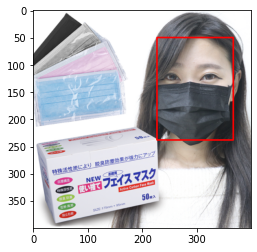

In [153]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [178]:
img = cv.imread('dataset/other_example.png')
h, w = img.shape[:2]
blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)), 1.0,
(300, 300), (104.0, 117.0, 123.0))
face_detector.setInput(blob)
faces = face_detector.forward()
for i in range(faces.shape[2]):
        confidence = faces[0, 0, i, 2]
        if confidence > 0.5:
            box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            cv.rectangle(img, (x, y), (x1, y1), (0, 0, 255), 2)

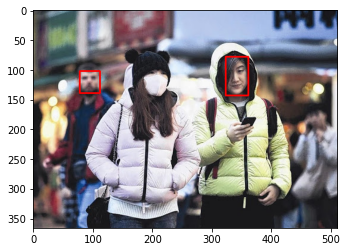

In [179]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

Wow, that's a notable improvement! This may also enable my model to be trained on higher amount of the data. Therefore, I will rebuild it in my application with the detector being dnn, not cascade classifier.

In [9]:
def get_faces(img, model, dimensions=(240, 240), for_display=False):
    h, w = img.shape[:2]
    blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
    model.setInput(blob)
    detected = model.forward()
    extracted = []
    coordinates = []
    for i in range(detected.shape[2]):
        confidence = detected[0, 0, i, 2]
        if confidence > 0.5:
            box = detected[0, 0, i, 3:7] * np.array([w, h, w, h])
            coords = box.astype("int")
            crop_img = img[coords[1]:coords[3], coords[0]:coords[2]]
            crop_img = cv.resize(crop_img, dimensions)
            crop_img = cv.cvtColor(crop_img, cv.COLOR_BGR2GRAY)
            extracted.append(crop_img)
            if for_display:
                coordinates.append(coords)
    if len(extracted)==0:
        return None
    if for_display:
        return extracted, coordinates
    return extracted

In [10]:
mfaces = [get_faces(image, face_detector) for image in masked_train if get_faces(image, face_detector) is not None]
mfaces = [face for image in mfaces for face in image]

ufaces = [get_faces(image, face_detector) for image in unmasked_train if get_faces(image, face_detector) is not None]
ufaces = [face for image in ufaces for face in image]

ifaces = [get_faces(image, face_detector) for image in incorrect_train if get_faces(image, face_detector) is not None]
ifaces = [face for image in ifaces for face in image]

In [11]:
mfaces_lbl = [2]* len(mfaces)
ifaces_lbl = [1]* len(ifaces)
ufaces_lbl = [0]* len(ufaces)

In [12]:
x_train = mfaces + ufaces + ifaces
Y_train = mfaces_lbl + ufaces_lbl + ifaces_lbl
X_train = (np.array(x_train)).reshape((len(Y_train), -1))

In [13]:
mtest, mcoords = map(list,zip(*[get_faces(image, face_detector, for_display=True) for image in masked_test if get_faces(image, face_detector) is not None]))
mtest = [face for image in mtest for face in image]

itest, icoords = map(list,zip(*[get_faces(image, face_detector, for_display=True) for image in incorrect_test if get_faces(image, face_detector) is not None]))
itest = [face for image in itest for face in image]

utest, ucoords = map(list,zip(*[get_faces(image, face_detector, for_display=True) for image in unmasked_test if get_faces(image, face_detector) is not None]))
utest = [face for image in utest for face in image]

mtest_lbl = [2]* len(mtest)
itest_lbl = [1]* len(itest)
utest_lbl = [0]* len(utest)

In [14]:
test_coords = mcoords + ucoords + icoords
x_test = mtest + utest + itest
Y_test = mtest_lbl + utest_lbl + itest_lbl
X_test = (np.array(x_test)).reshape((len(Y_test), -1))

In [15]:
from sklearn.ensemble import RandomForestClassifier
mask_detector = RandomForestClassifier().fit(X_train, Y_train)
mask_detector.score(X_test, Y_test)

0.9179734620024126

Well, it seems that even the model accuracy improved (before uploading more data it did). That's wonderful. Now I will see it work on the image with the two faces detected.

In [16]:
img = cv.imread('dataset/other_example.png')

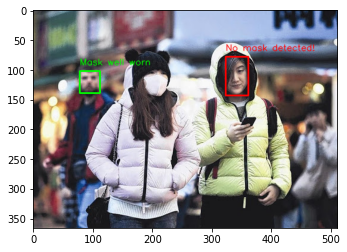

In [20]:
faces, coords = get_faces(img, face_detector, for_display=True)
faces_flattened = (np.array(faces)).reshape((len(coords), -1))
res = mask_detector.predict(faces_flattened)
font = cv.FONT_HERSHEY_SIMPLEX
img_display = cv.cvtColor(img, cv.COLOR_BGR2RGB)
i = 0
for coord in coords:
    cv.rectangle(img_display, (coord[0], coord[1]), (coord[2], coord[3]), mask_coloring[res[i]], 2)
    cv.putText(img_display,mask_result[res[i]],(coord[0], coord[1]-10), fontFace = font, fontScale=0.5, color=mask_coloring[res[i]],thickness=1, lineType=cv.LINE_AA)
    i += 1
plt.imshow(img_display)

One of the classes is wrong, unfortunately. However, I will check if the mask on the other picture is finally detected.

In [21]:
img = cv.imread('dataset/other.png')

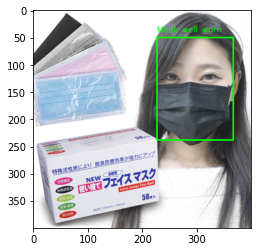

In [22]:
faces, coords = get_faces(img, face_detector, for_display=True)
faces_flattened = (np.array(faces)).reshape((len(coords), -1))
res = mask_detector.predict(faces_flattened)
font = cv.FONT_HERSHEY_SIMPLEX
img_display = cv.cvtColor(img, cv.COLOR_BGR2RGB)
i = 0
for coord in coords:
    cv.rectangle(img_display, (coord[0], coord[1]), (coord[2], coord[3]), mask_coloring[res[i]], 2)
    cv.putText(img_display,mask_result[res[i]],(coord[0], coord[1]-10), fontFace = font, fontScale=0.5, color=mask_coloring[res[i]],thickness=1, lineType=cv.LINE_AA)
    i += 1
plt.imshow(img_display)

In [ ]:
Yes! The model finally detects real masks.

Having improved my model, I can implement more efficient application.

## Dataset concerns

As I proceed with the application making, I realise that the images from outside the dataset of people with mask on are not correctly classified. I suspect this is because the dataset consists mostly of faces with masks generated and placed on them instead of actual masked people. Because of that, I once again trained the model - with additional data. The folders were simply enhanced and the improved model ran again.